In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import joblib
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
%matplotlib inline
matplotlib.rcParams.update({'font.size': 20})

In [2]:
X_train = pd.read_pickle("/Users/ilseeb/Desktop/Postgraduate/Train Punctuality Data/train_test_data/X_train_processed.pkl")
y_train = pd.read_pickle("/Users/ilseeb/Desktop/Postgraduate/Train Punctuality Data/train_test_data/y_train_over.pkl")

In [3]:
X_train.columns

Index(['temperature', 'relative_humidity', 'wind_speed', 'wind_direction',
       'date', 'train_serv_BELGORAIL', 'train_serv_EUROSTAR',
       'train_serv_EUROSTARFR', 'train_serv_SNCB/NMBS', 'train_serv_THI-FACT',
       'month_APR', 'month_AUG', 'month_DEC', 'month_FEB', 'month_JAN',
       'month_JUL', 'month_JUN', 'month_MAR', 'month_MAY', 'month_NOV',
       'month_OCT', 'month_SEP', 'destination_region_BRUSSELS-CAPITAL REGION',
       'destination_region_FLANDERS', 'destination_region_WALLONIA',
       'departure_region_BRUSSELS-CAPITAL REGION', 'departure_region_FLANDERS',
       'departure_region_WALLONIA', 'time_of_day_afternoon',
       'time_of_day_morning', 'time_of_day_night', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday'],
      dtype='object')

In [4]:
X_train.drop(columns=["date"], inplace=True)

In [5]:
clf = RandomForestClassifier(
    n_estimators=50,
    criterion='gini',
    #max_depth=5,
    #max_features='auto',
    #n_jobs=-1,
    #class_weight='balanced'
)

K-fold cross validation

In [6]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

In [7]:
def compute_roc_auc(index):
    y_predict_prob = clf.predict_proba(X_train.iloc[index])[:,1]
    y_predict = clf.predict(X_train.iloc[index])
    fpr, tpr, thresholds = roc_curve(y_train.iloc[index], y_predict_prob)
    auc_score = auc(fpr, tpr)
    accuracy = accuracy_score(y_train.iloc[index], y_predict)
    precision = precision_score(y_train.iloc[index], y_predict)
    recall = recall_score(y_train.iloc[index], y_predict)
    return fpr, tpr, auc_score, accuracy, precision, recall

In [8]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

In [9]:
for (train, test), i in zip(cv.split(X_train, y_train), range(5)):
    clf.fit(X_train.iloc[train], y_train.iloc[train])
    _, _, auc_score_train, accuracy_train, precision_train, recall_train = compute_roc_auc(train)
    fpr, tpr, auc_score, accuracy, precision, recall = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score, accuracy_train, accuracy
                   ,precision_train, precision, recall_train, recall))
    fprs.append(fpr)
    tprs.append(tpr)

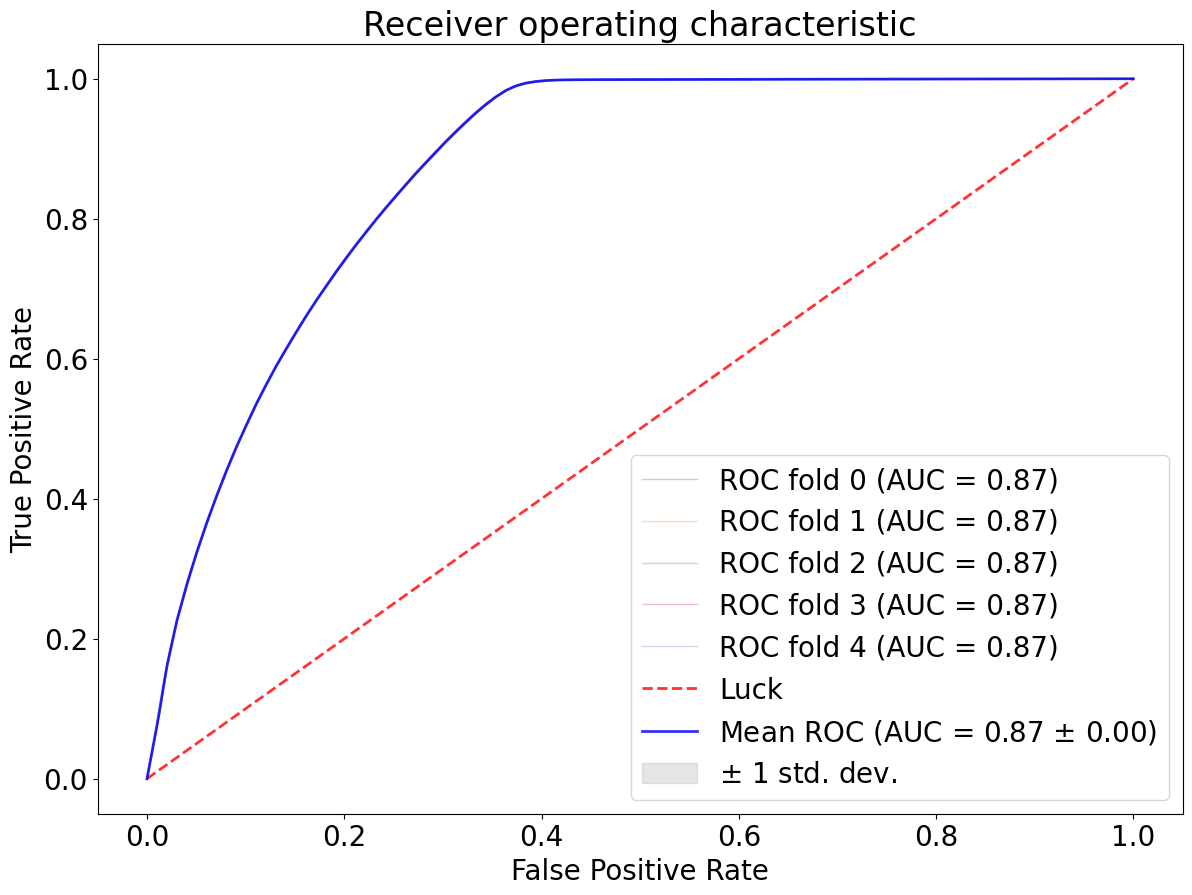

,AUC Train,AUC Test,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test
0,0.917288,0.871597,0.838583,0.801101,0.784022,0.753096,0.934635,0.895937
1,0.917271,0.871782,0.838449,0.801620,0.784231,0.754188,0.933828,0.894920
2,0.917363,0.871214,0.838623,0.800773,0.784243,0.752953,0.934279,0.895298
3,0.917322,0.871725,0.838483,0.801758,0.783935,0.753928,0.934540,0.895937
4,0.917363,0.871326,0.838591,0.800863,0.784463,0.753435,0.933731,0.894433


In [10]:
plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'
                              , 'Accuracy Train', 'Accuracy Test'
                              ,'Precision Train', 'Precision Test'
                              ,'Recall Train', 'Recall Test'])

In [11]:
# save
joblib.dump(clf, "/Users/ilseeb/Desktop/Postgraduate/Train Punctuality Data/Models/random_forest_v1.joblib")

['/Users/ilseeb/Desktop/Postgraduate/Train Punctuality Data/Models/random_forest_v1.joblib']

In [12]:
# remove type of train
X_train_v2 = X_train[['temperature', 'relative_humidity', 'wind_speed', 'wind_direction',
       'month_APR', 'month_AUG', 'month_DEC', 'month_FEB', 'month_JAN',
       'month_JUL', 'month_JUN', 'month_MAR', 'month_MAY', 'month_NOV',
       'month_OCT', 'month_SEP', 'destination_region_BRUSSELS-CAPITAL REGION',
       'destination_region_FLANDERS', 'destination_region_WALLONIA',
       'departure_region_BRUSSELS-CAPITAL REGION', 'departure_region_FLANDERS',
       'departure_region_WALLONIA', 'time_of_day_afternoon',
       'time_of_day_morning', 'time_of_day_night', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday']]

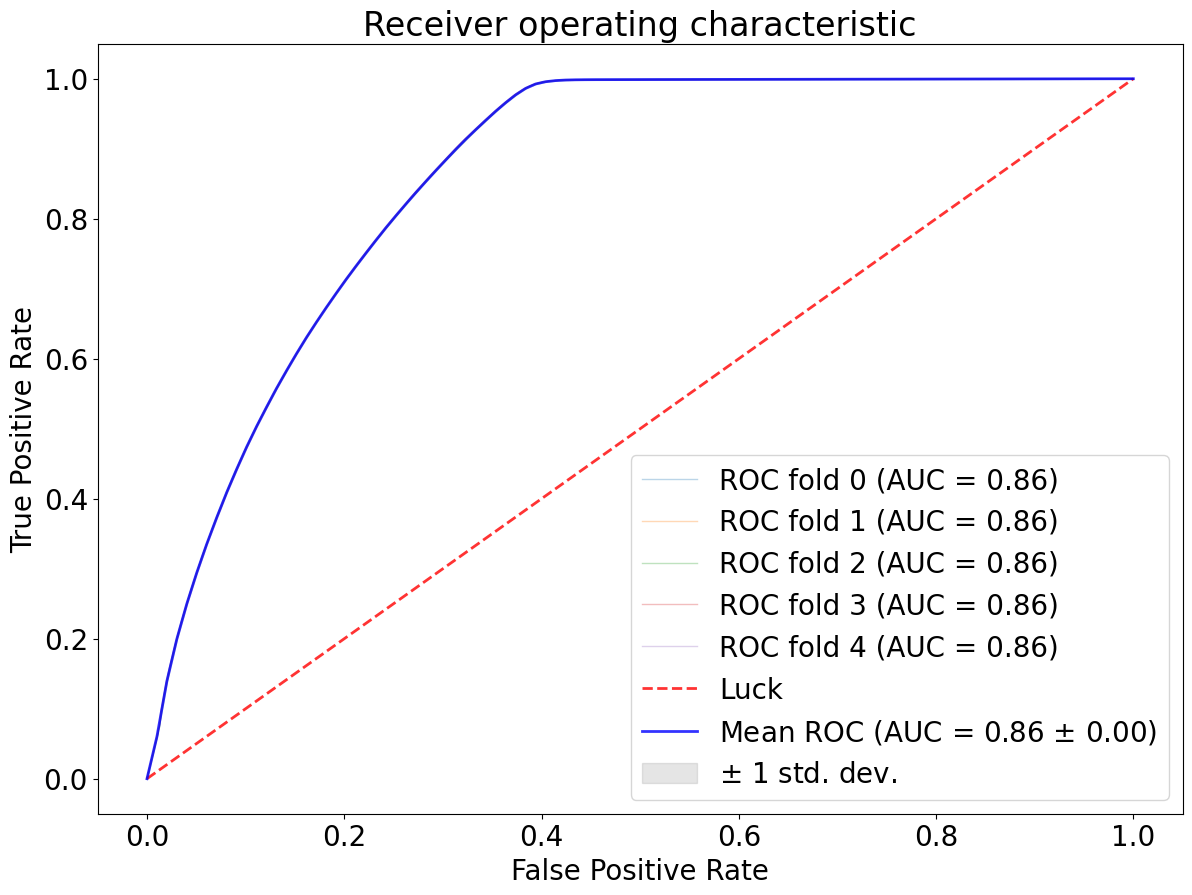

,AUC Train,AUC Test,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test
0,0.907787,0.861015,0.828237,0.790795,0.773889,0.743712,0.927452,0.887390
1,0.907800,0.861211,0.828126,0.791395,0.774001,0.744578,0.926893,0.887102
2,0.907820,0.860899,0.828230,0.790945,0.773961,0.743859,0.927276,0.887492
3,0.907869,0.861064,0.828168,0.791356,0.773789,0.744608,0.927475,0.886913
4,0.907804,0.861154,0.828218,0.790810,0.774148,0.744217,0.926833,0.886201


In [16]:
def compute_roc_auc(index):
    y_predict_prob = clf.predict_proba(X_train_v2.iloc[index])[:,1]
    y_predict = clf.predict(X_train_v2.iloc[index])
    fpr, tpr, thresholds = roc_curve(y_train.iloc[index], y_predict_prob)
    auc_score = auc(fpr, tpr)
    accuracy = accuracy_score(y_train.iloc[index], y_predict)
    precision = precision_score(y_train.iloc[index], y_predict)
    recall = recall_score(y_train.iloc[index], y_predict)
    return fpr, tpr, auc_score, accuracy, precision, recall

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X_train_v2, y_train), range(5)):
    clf.fit(X_train_v2.iloc[train], y_train.iloc[train])
    _, _, auc_score_train, accuracy_train, precision_train, recall_train = compute_roc_auc(train)
    fpr, tpr, auc_score, accuracy, precision, recall = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score, accuracy_train, accuracy
                   ,precision_train, precision, recall_train, recall))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'
                              , 'Accuracy Train', 'Accuracy Test'
                              ,'Precision Train', 'Precision Test'
                              ,'Recall Train', 'Recall Test'])

In [39]:
# remove temperature and wind direction
X_train_v3 = X_train[['relative_humidity', 'wind_speed',
       'month_APR', 'month_AUG', 'month_DEC', 'month_FEB', 'month_JAN',
       'month_JUL', 'month_JUN', 'month_MAR', 'month_MAY', 'month_NOV',
       'month_OCT', 'month_SEP', 'destination_region_BRUSSELS-CAPITAL REGION',
       'destination_region_FLANDERS', 'destination_region_WALLONIA',
       'departure_region_BRUSSELS-CAPITAL REGION', 'departure_region_FLANDERS',
       'departure_region_WALLONIA', 'time_of_day_afternoon',
       'time_of_day_morning', 'time_of_day_night', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday']]

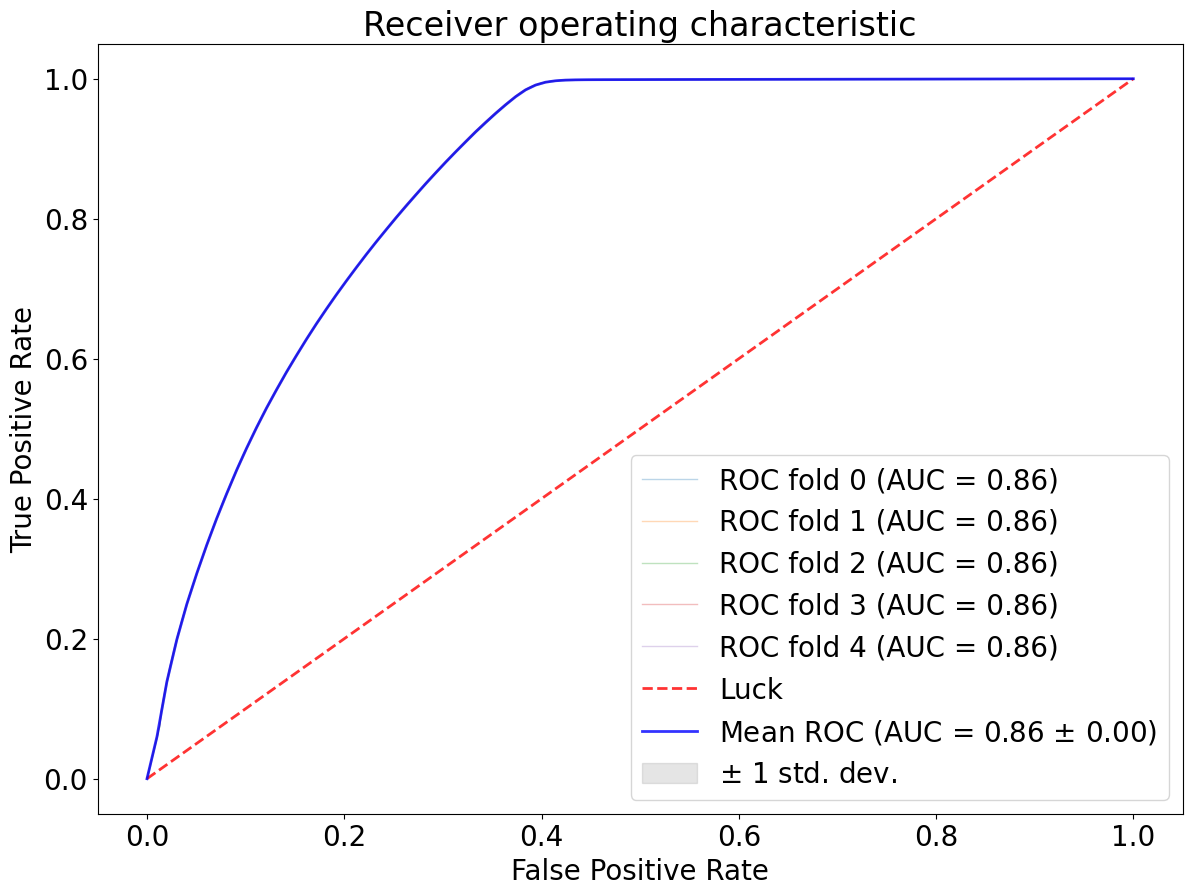

,AUC Train,AUC Test,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test
0,0.907772,0.860183,0.828221,0.789880,0.774041,0.742639,0.927074,0.887228
1,0.907784,0.860396,0.828106,0.790375,0.774080,0.743309,0.926666,0.887097
2,0.907806,0.860036,0.828229,0.789844,0.774090,0.742684,0.926991,0.887008
3,0.907855,0.860129,0.828165,0.790099,0.773838,0.742968,0.927360,0.887090
4,0.907788,0.860237,0.828215,0.789835,0.773893,0.742695,0.927381,0.886954


In [40]:
def compute_roc_auc(index):
    y_predict_prob = clf.predict_proba(X_train_v3.iloc[index])[:,1]
    y_predict = clf.predict(X_train_v3.iloc[index])
    fpr, tpr, thresholds = roc_curve(y_train.iloc[index], y_predict_prob)
    auc_score = auc(fpr, tpr)
    accuracy = accuracy_score(y_train.iloc[index], y_predict)
    precision = precision_score(y_train.iloc[index], y_predict)
    recall = recall_score(y_train.iloc[index], y_predict)
    return fpr, tpr, auc_score, accuracy, precision, recall

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X_train_v3, y_train), range(5)):
    clf.fit(X_train_v3.iloc[train], y_train.iloc[train])
    _, _, auc_score_train, accuracy_train, precision_train, recall_train = compute_roc_auc(train)
    fpr, tpr, auc_score, accuracy, precision, recall = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score, accuracy_train, accuracy
                   ,precision_train, precision, recall_train, recall))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'
                              , 'Accuracy Train', 'Accuracy Test'
                              ,'Precision Train', 'Precision Test'
                              ,'Recall Train', 'Recall Test'])

In [41]:
# remove relative humidity and wind speed
X_train_v4 = X_train[['month_APR', 'month_AUG', 'month_DEC', 'month_FEB', 'month_JAN',
       'month_JUL', 'month_JUN', 'month_MAR', 'month_MAY', 'month_NOV',
       'month_OCT', 'month_SEP', 'destination_region_BRUSSELS-CAPITAL REGION',
       'destination_region_FLANDERS', 'destination_region_WALLONIA',
       'departure_region_BRUSSELS-CAPITAL REGION', 'departure_region_FLANDERS',
       'departure_region_WALLONIA', 'time_of_day_afternoon',
       'time_of_day_morning', 'time_of_day_night', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday']]

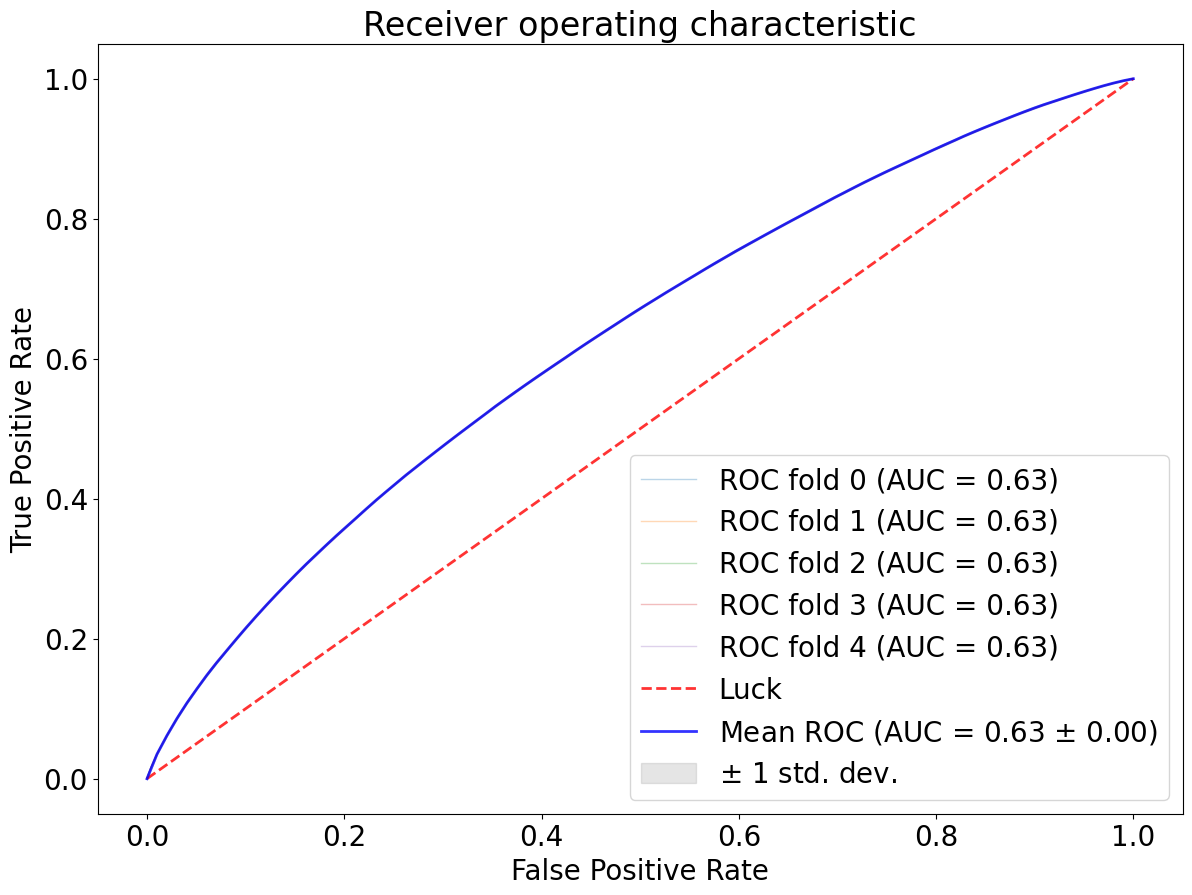

,AUC Train,AUC Test,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test
0,0.628402,0.627439,0.590450,0.589769,0.596198,0.595459,0.560571,0.559961
1,0.628572,0.626800,0.590560,0.589299,0.595647,0.594243,0.563966,0.563063
2,0.628621,0.626598,0.590656,0.589098,0.596299,0.594590,0.561354,0.560069
3,0.628533,0.626968,0.590472,0.589643,0.595976,0.595439,0.561797,0.559279
4,0.628570,0.626765,0.590626,0.589384,0.596858,0.595323,0.558458,0.558232


In [42]:
def compute_roc_auc(index):
    y_predict_prob = clf.predict_proba(X_train_v4.iloc[index])[:,1]
    y_predict = clf.predict(X_train_v4.iloc[index])
    fpr, tpr, thresholds = roc_curve(y_train.iloc[index], y_predict_prob)
    auc_score = auc(fpr, tpr)
    accuracy = accuracy_score(y_train.iloc[index], y_predict)
    precision = precision_score(y_train.iloc[index], y_predict)
    recall = recall_score(y_train.iloc[index], y_predict)
    return fpr, tpr, auc_score, accuracy, precision, recall

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X_train_v4, y_train), range(5)):
    clf.fit(X_train_v4.iloc[train], y_train.iloc[train])
    _, _, auc_score_train, accuracy_train, precision_train, recall_train = compute_roc_auc(train)
    fpr, tpr, auc_score, accuracy, precision, recall = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score, accuracy_train, accuracy
                   ,precision_train, precision, recall_train, recall))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'
                              , 'Accuracy Train', 'Accuracy Test'
                              ,'Precision Train', 'Precision Test'
                              ,'Recall Train', 'Recall Test'])

In [48]:
# adding back relative humidity
X_train_v5 = X_train[['relative_humidity', 'month_APR', 'month_AUG', 'month_DEC', 'month_FEB', 'month_JAN',
       'month_JUL', 'month_JUN', 'month_MAR', 'month_MAY', 'month_NOV',
       'month_OCT', 'month_SEP', 'destination_region_BRUSSELS-CAPITAL REGION',
       'destination_region_FLANDERS', 'destination_region_WALLONIA',
       'departure_region_BRUSSELS-CAPITAL REGION', 'departure_region_FLANDERS',
       'departure_region_WALLONIA', 'time_of_day_afternoon',
       'time_of_day_morning', 'time_of_day_night', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday']]

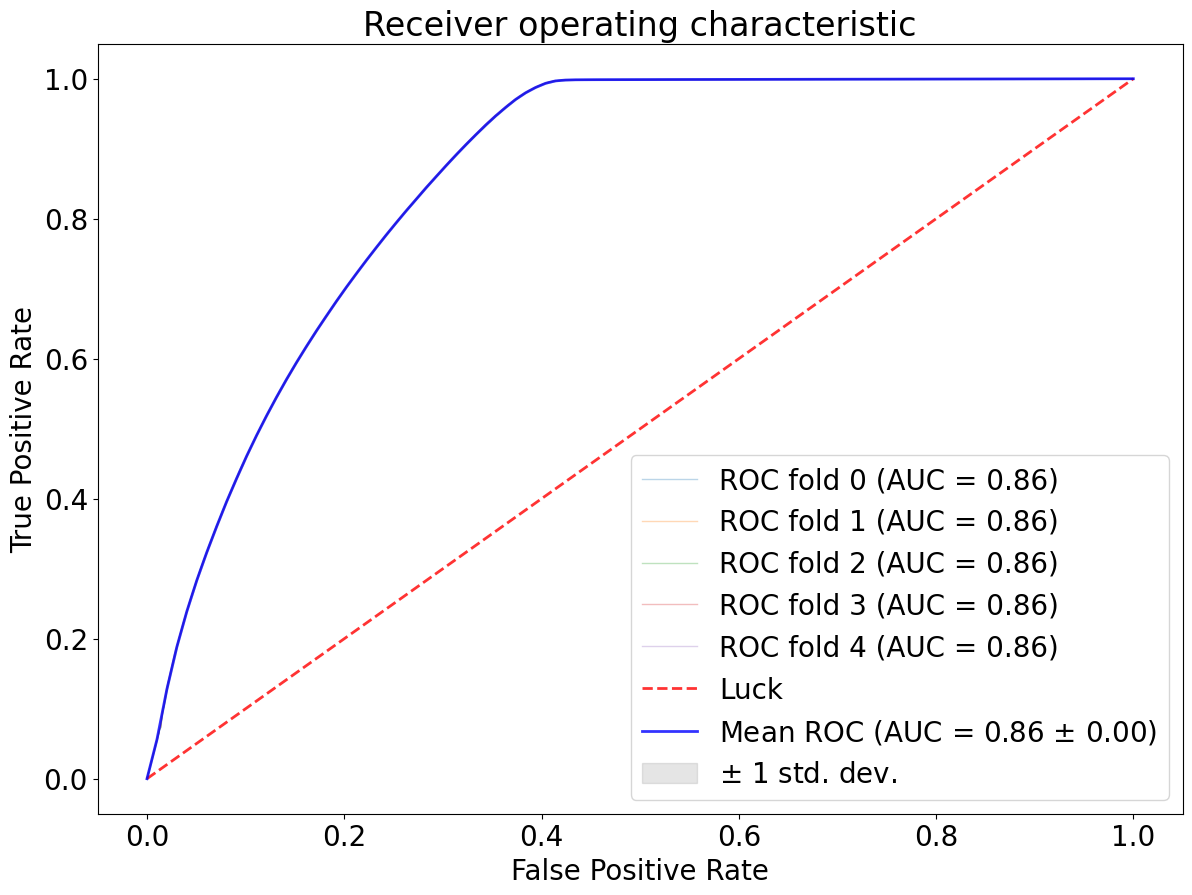

,AUC Train,AUC Test,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test
0,0.907645,0.857039,0.828142,0.788247,0.773910,0.740557,0.927139,0.887370
1,0.907667,0.857132,0.828037,0.788437,0.773891,0.740935,0.926884,0.887015
2,0.907681,0.856877,0.828156,0.788205,0.773766,0.740389,0.927491,0.887661
3,0.907731,0.856926,0.828081,0.788454,0.773753,0.740864,0.927307,0.887245
4,0.907669,0.856886,0.828127,0.788008,0.773848,0.740576,0.927230,0.886588


In [49]:
def compute_roc_auc(index):
    y_predict_prob = clf.predict_proba(X_train_v5.iloc[index])[:,1]
    y_predict = clf.predict(X_train_v5.iloc[index])
    fpr, tpr, thresholds = roc_curve(y_train.iloc[index], y_predict_prob)
    auc_score = auc(fpr, tpr)
    accuracy = accuracy_score(y_train.iloc[index], y_predict)
    precision = precision_score(y_train.iloc[index], y_predict)
    recall = recall_score(y_train.iloc[index], y_predict)
    return fpr, tpr, auc_score, accuracy, precision, recall

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X_train_v5, y_train), range(5)):
    clf.fit(X_train_v5.iloc[train], y_train.iloc[train])
    _, _, auc_score_train, accuracy_train, precision_train, recall_train = compute_roc_auc(train)
    fpr, tpr, auc_score, accuracy, precision, recall = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score, accuracy_train, accuracy
                   ,precision_train, precision, recall_train, recall))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'
                              , 'Accuracy Train', 'Accuracy Test'
                              ,'Precision Train', 'Precision Test'
                              ,'Recall Train', 'Recall Test'])

In [54]:
# remove time of day
X_train_v6 = X_train[['relative_humidity', 'wind_speed',
       'month_APR', 'month_AUG', 'month_DEC', 'month_FEB', 'month_JAN',
       'month_JUL', 'month_JUN', 'month_MAR', 'month_MAY', 'month_NOV',
       'month_OCT', 'month_SEP', 'destination_region_BRUSSELS-CAPITAL REGION',
       'destination_region_FLANDERS', 'destination_region_WALLONIA',
       'departure_region_BRUSSELS-CAPITAL REGION', 'departure_region_FLANDERS',
       'departure_region_WALLONIA', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday']]

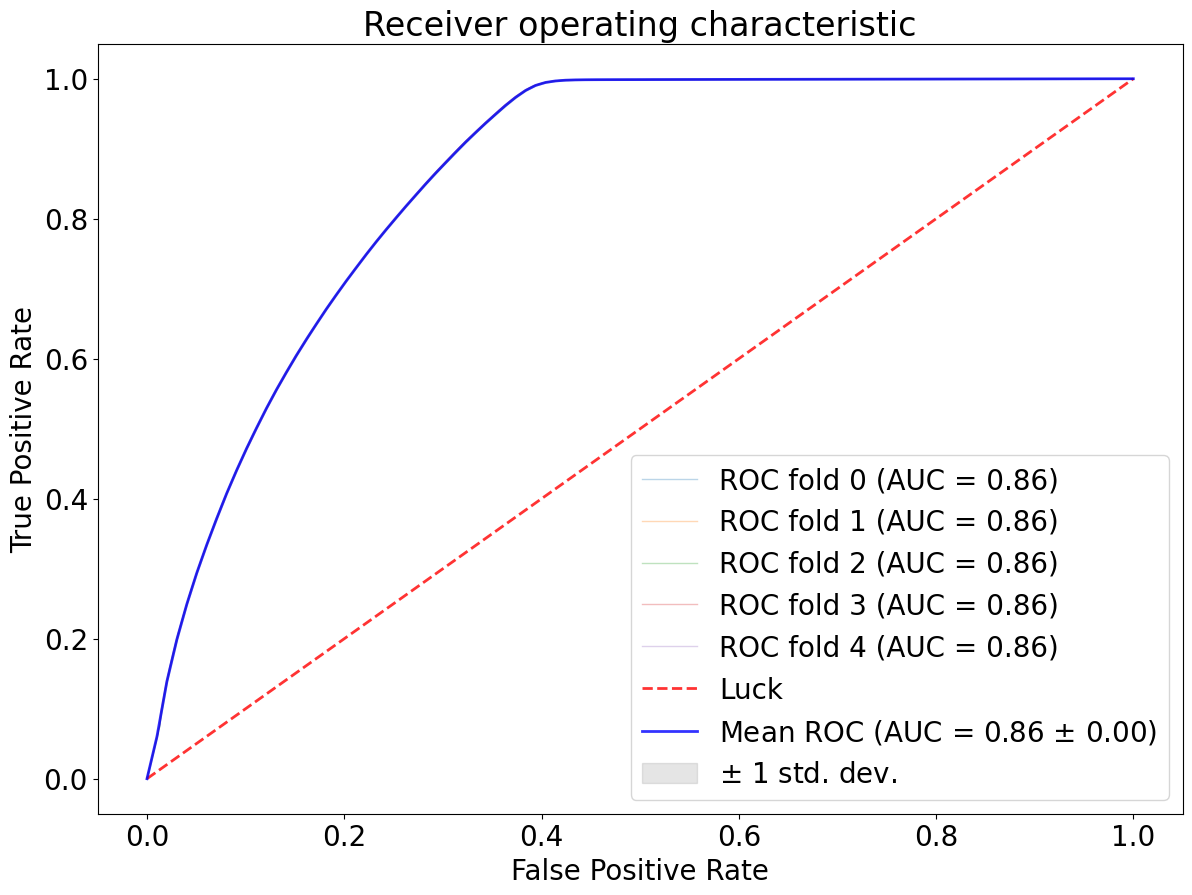

,AUC Train,AUC Test,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test
0,0.907771,0.860022,0.828228,0.789646,0.773901,0.742214,0.927400,0.887559
1,0.907788,0.860375,0.828113,0.790251,0.773924,0.743092,0.927027,0.887247
2,0.907804,0.859878,0.828230,0.789292,0.774089,0.742098,0.926995,0.886761
3,0.907850,0.860034,0.828157,0.790102,0.773893,0.743094,0.927218,0.886790
4,0.907790,0.860165,0.828210,0.789663,0.774107,0.742733,0.926900,0.886334


In [55]:
def compute_roc_auc(index):
    y_predict_prob = clf.predict_proba(X_train_v6.iloc[index])[:,1]
    y_predict = clf.predict(X_train_v6.iloc[index])
    fpr, tpr, thresholds = roc_curve(y_train.iloc[index], y_predict_prob)
    auc_score = auc(fpr, tpr)
    accuracy = accuracy_score(y_train.iloc[index], y_predict)
    precision = precision_score(y_train.iloc[index], y_predict)
    recall = recall_score(y_train.iloc[index], y_predict)
    return fpr, tpr, auc_score, accuracy, precision, recall

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X_train_v6, y_train), range(5)):
    clf.fit(X_train_v6.iloc[train], y_train.iloc[train])
    _, _, auc_score_train, accuracy_train, precision_train, recall_train = compute_roc_auc(train)
    fpr, tpr, auc_score, accuracy, precision, recall = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score, accuracy_train, accuracy
                   ,precision_train, precision, recall_train, recall))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'
                              , 'Accuracy Train', 'Accuracy Test'
                              ,'Precision Train', 'Precision Test'
                              ,'Recall Train', 'Recall Test'])

In [56]:
# remove day of week
X_train_v7 = X_train[['relative_humidity', 'wind_speed',
       'month_APR', 'month_AUG', 'month_DEC', 'month_FEB', 'month_JAN',
       'month_JUL', 'month_JUN', 'month_MAR', 'month_MAY', 'month_NOV',
       'month_OCT', 'month_SEP', 'destination_region_BRUSSELS-CAPITAL REGION',
       'destination_region_FLANDERS', 'destination_region_WALLONIA',
       'departure_region_BRUSSELS-CAPITAL REGION', 'departure_region_FLANDERS',
       'departure_region_WALLONIA']]

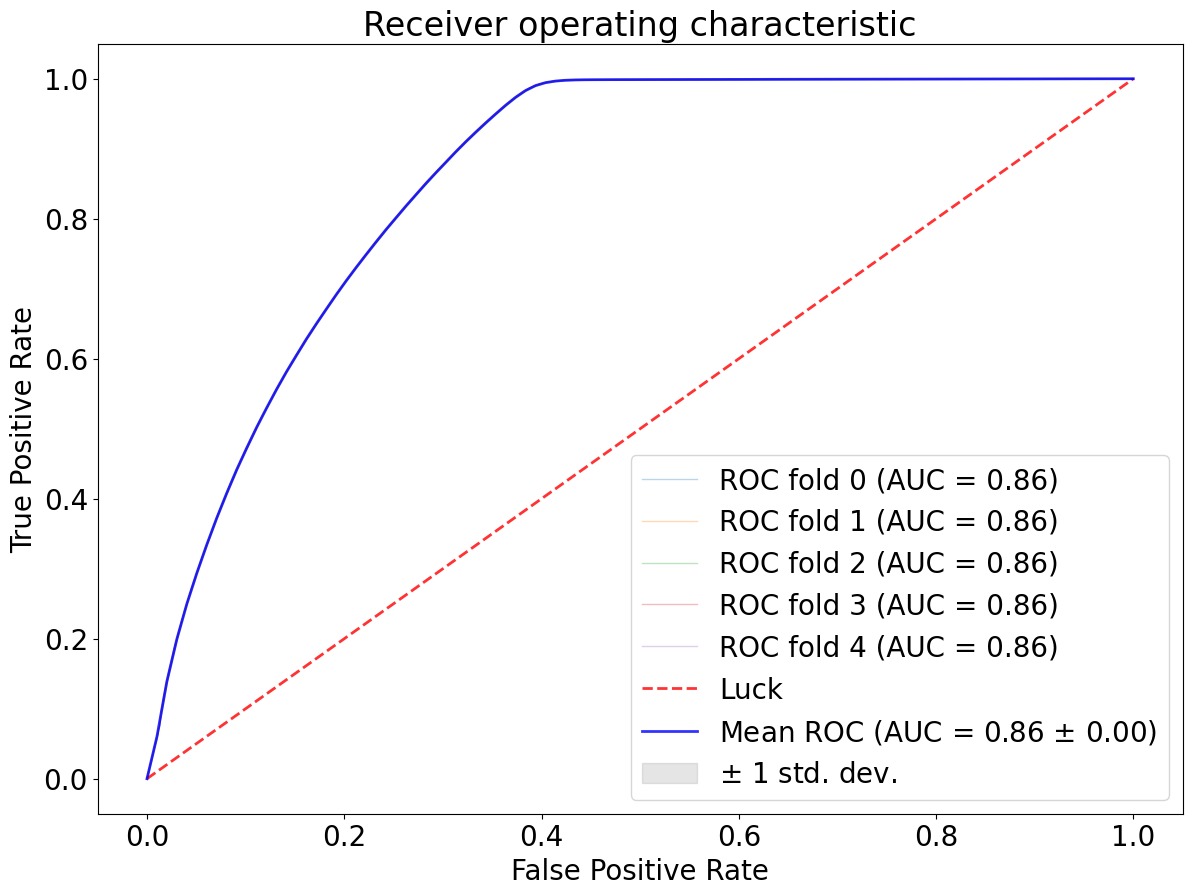

,AUC Train,AUC Test,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test
0,0.907773,0.860153,0.828225,0.789765,0.773945,0.742451,0.927296,0.887339
1,0.907783,0.860416,0.828114,0.790169,0.774080,0.743182,0.926689,0.886777
2,0.907808,0.859941,0.828235,0.789709,0.773918,0.742383,0.927382,0.887337
3,0.907850,0.860086,0.828153,0.790133,0.773715,0.742930,0.927597,0.887288
4,0.907791,0.860264,0.828213,0.789752,0.774031,0.742778,0.927074,0.886494


In [57]:
def compute_roc_auc(index):
    y_predict_prob = clf.predict_proba(X_train_v7.iloc[index])[:,1]
    y_predict = clf.predict(X_train_v7.iloc[index])
    fpr, tpr, thresholds = roc_curve(y_train.iloc[index], y_predict_prob)
    auc_score = auc(fpr, tpr)
    accuracy = accuracy_score(y_train.iloc[index], y_predict)
    precision = precision_score(y_train.iloc[index], y_predict)
    recall = recall_score(y_train.iloc[index], y_predict)
    return fpr, tpr, auc_score, accuracy, precision, recall

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X_train_v7, y_train), range(5)):
    clf.fit(X_train_v7.iloc[train], y_train.iloc[train])
    _, _, auc_score_train, accuracy_train, precision_train, recall_train = compute_roc_auc(train)
    fpr, tpr, auc_score, accuracy, precision, recall = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score, accuracy_train, accuracy
                   ,precision_train, precision, recall_train, recall))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'
                              , 'Accuracy Train', 'Accuracy Test'
                              ,'Precision Train', 'Precision Test'
                              ,'Recall Train', 'Recall Test'])

In [59]:
# remove departure region
X_train_v8 = X_train[['relative_humidity', 'wind_speed',
              'month_APR', 'month_AUG', 'month_DEC', 'month_FEB', 'month_JAN',
              'month_JUL', 'month_JUN', 'month_MAR', 'month_MAY', 'month_NOV',
              'month_OCT', 'month_SEP', 'destination_region_BRUSSELS-CAPITAL REGION',
              'destination_region_FLANDERS', 'destination_region_WALLONIA',
              'day_of_week_Friday',
              'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
              'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday']]

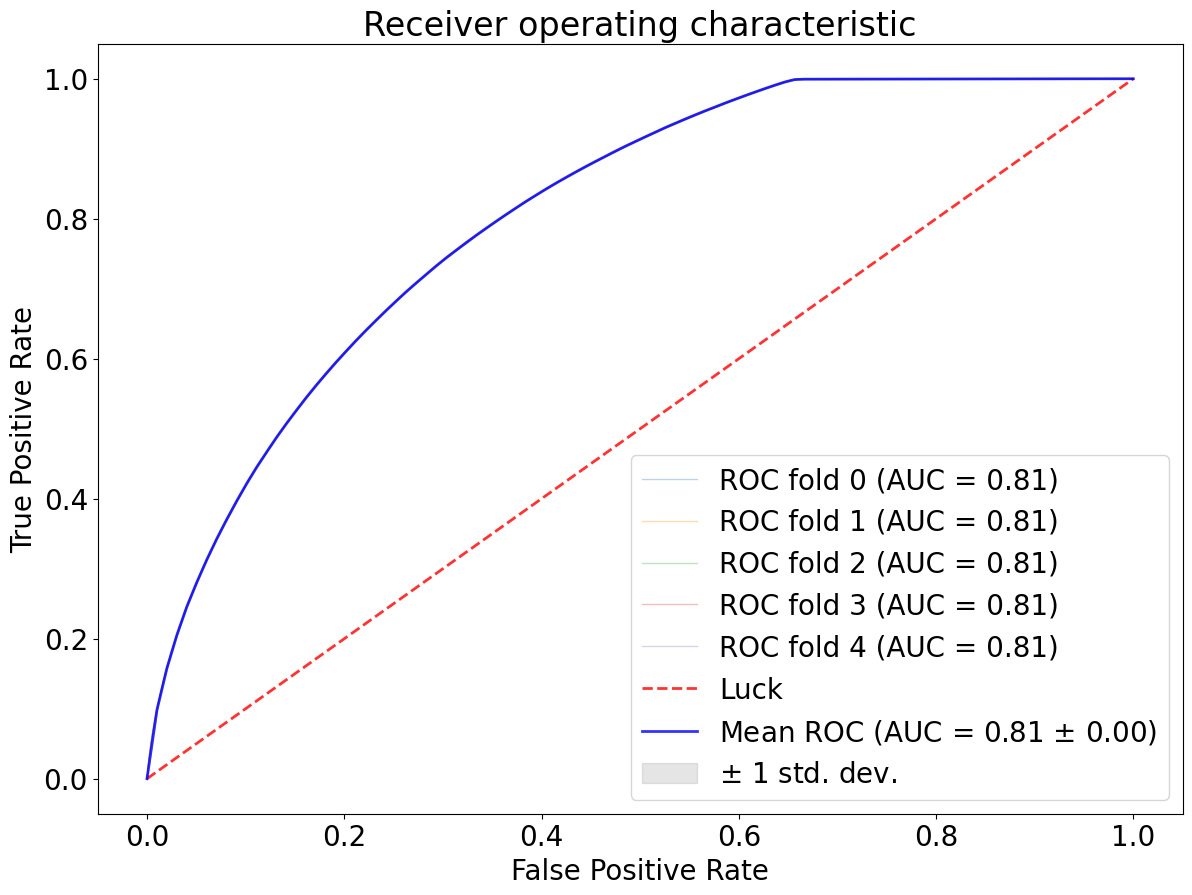

,AUC Train,AUC Test,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test
0,0.840545,0.806331,0.752286,0.720983,0.725235,0.697125,0.812339,0.781499
1,0.840550,0.806480,0.752221,0.721641,0.725438,0.697977,0.811624,0.781404
2,0.840517,0.806392,0.752230,0.721374,0.725051,0.697698,0.812612,0.781257
3,0.840636,0.806212,0.752224,0.720971,0.725294,0.696926,0.811990,0.782025
4,0.840567,0.806435,0.752258,0.721247,0.725349,0.697473,0.811962,0.781443


In [60]:
def compute_roc_auc(index):
    y_predict_prob = clf.predict_proba(X_train_v8.iloc[index])[:,1]
    y_predict = clf.predict(X_train_v8.iloc[index])
    fpr, tpr, thresholds = roc_curve(y_train.iloc[index], y_predict_prob)
    auc_score = auc(fpr, tpr)
    accuracy = accuracy_score(y_train.iloc[index], y_predict)
    precision = precision_score(y_train.iloc[index], y_predict)
    recall = recall_score(y_train.iloc[index], y_predict)
    return fpr, tpr, auc_score, accuracy, precision, recall

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X_train_v8, y_train), range(5)):
    clf.fit(X_train_v8.iloc[train], y_train.iloc[train])
    _, _, auc_score_train, accuracy_train, precision_train, recall_train = compute_roc_auc(train)
    fpr, tpr, auc_score, accuracy, precision, recall = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score, accuracy_train, accuracy
                   ,precision_train, precision, recall_train, recall))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'
                              , 'Accuracy Train', 'Accuracy Test'
                              ,'Precision Train', 'Precision Test'
                              ,'Recall Train', 'Recall Test'])